<a href="https://colab.research.google.com/github/allenc3/Variational_AutoEncoder/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)

In [0]:
!pip install imageio
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
from tensorflow.contrib.slim import fully_connected as fc
import tensorflow as tf
from scipy import misc
import imageio
import os

In [0]:
image_file_list = []
for image_path in glob.glob("/content/drive/My Drive/ResearchDatav2/*.png"):
    image_file_list.append(image_path)

In [0]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/Data_Entry_2017.csv', delimiter = ',')

imagelist = []
num_samples = 0
for i in df.index:
    if (df["View Position"][i] == "PA"):
        file_name = "/content/drive/My Drive/ResearchDatav2/" + df["Image Index"][i]
        if (file_name in image_file_list):
            imagelist.append(file_name)

num_samples = len(imagelist)
print("Samples:", num_samples)

Samples: 5725


In [0]:
# might need to add test images here
from random import shuffle

test_sample_size = 2000
valid_sample_size = 200
# test_sample_size = 200

shuffle(imagelist)

proper_shape = (64,64)
num_samples = test_sample_size

total_set = []
total_file = []
offset = 0
cur_size = 0
while(cur_size < 2500):
    image = imageio.imread(imagelist[cur_size + offset])
    if image.shape != (64,64):
        offset += 1
    else:
        total_set.append(image.reshape(64, 64, 1))
        total_file.append(imagelist[cur_size + offset])
        cur_size += 1
        
        
test_set = total_set[2000:2250]
train_set = total_set[0:2000]
valid_set = total_set[2250:2500]

In [0]:
with open('train.txt', 'w') as f:
    for item in total_file[0:2000]:
        f.write("%s\n" % item)
        
with open('test.txt', 'w') as f:
    for item in total_file[2000:2250]:
        f.write("%s\n" % item)
        
with open('valid_set.txt', 'w') as f:
    for item in total_file[2250:2500]:
        f.write("%s\n" % item)

In [0]:
with open('test.txt') as f:
    test_set = f.read().splitlines()
with open('train.txt') as f:
    train_set = f.read().splitlines()
with open('valid_set.txt') as f:
    valid_set = f.read().splitlines()

test_set = [imageio.imread(image_file).reshape(64, 64, 1) for image_file in test_set]
train_set = [imageio.imread(image_file).reshape(64, 64, 1) for image_file in train_set]
valid_set = [imageio.imread(image_file).reshape(64, 64, 1) for image_file in valid_set]



In [0]:
for i in valid_set:
    if (i.shape != (64, 64, 1)):
        print(i.shape)


In [0]:
def get_next_batch(iteration, batch_size):
    if iteration == 0:
        shuffle(train_set)
    return train_set[batch_size*iteration : (iteration+1) * batch_size]

def valid_get_next_batch(iteration, batch_size):
    if iteration == 0:
        shuffle(valid_set)
    return valid_set[batch_size*iteration : (iteration+1) * batch_size]

def test_get_next_batch(iteration, batch_size):
    if iteration == 0:
        shuffle(test_set)
    return test_set[batch_size*iteration : (iteration+1) * batch_size]

In [0]:
w = 64
h = 64
input_dim = w * h

In [0]:
class VariationalAutoEncoder(object): 
  
    def __init__(self, learning_rate=0.001, batch_size=100, n_z =10): 
        
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z # Latent vector dimensions
        
        self.build()       
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
#         self.sess = sess;
        
    
    def build(self):
        self.input = tf.placeholder(name='input', dtype=tf.float32, shape=[None, w, h, 1])
        self.input_flat = tf.reshape(self.input, shape=[-1, w*h])

        self.encoder()
        self.decoder()
        self.calculate_loss()

        return 
    # Encoder convolution layers
    def conv2_pool(self, input, filter_size):
        conv1 = tf.layers.conv2d(inputs=input, filters=filter_size, kernel_size=(3,3), padding='same', activation=tf.nn.elu)        
        conv1_2 = tf.layers.conv2d(inputs=conv1, filters=filter_size, kernel_size=(3,3), padding='same', activation=tf.nn.elu)
        maxpool = tf.layers.max_pooling2d(conv1_2, pool_size=(2,2), strides=(2,2), padding='same')  
        
        return maxpool
    
    def conv3_pool(self, input, filter_size):
        conv1 = tf.layers.conv2d(inputs=input, filters=filter_size, kernel_size=(3,3), padding='same', activation=tf.nn.elu)         
        conv1_2 = tf.layers.conv2d(inputs=conv1, filters=filter_size, kernel_size=(3,3), padding='same', activation=tf.nn.elu)
        conv1_3 = tf.layers.conv2d(inputs=conv1_2, filters=filter_size, kernel_size=(3,3), padding='same', activation=tf.nn.elu)
        maxpool = tf.layers.max_pooling2d(conv1_3, pool_size=(2,2), strides=(2,2), padding='same')  
        
        return maxpool
    
    # Decoder convolution layers
    def upsample_conv_2(self, input, filter_size, dim_size):
        upsample1 = tf.image.resize_images(input, size=(dim_size, dim_size), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)          
        conv1 = tf.layers.conv2d(inputs=upsample1, filters=filter_size, kernel_size=(3,3), padding='same', activation=tf.nn.elu)   
        conv1_2 = tf.layers.conv2d(inputs=conv1, filters=filter_size, kernel_size=(3,3), padding='same', activation=tf.nn.elu)
        
        return conv1_2
    
    def upsample_conv_3(self, input, filter_size, dim_size):
        upsample1 = tf.image.resize_images(input, size=(dim_size, dim_size), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)          
        conv1 = tf.layers.conv2d(inputs=upsample1, filters=filter_size, kernel_size=(3,3), padding='same', activation=tf.nn.elu)   
        conv1_2 = tf.layers.conv2d(inputs=conv1, filters=filter_size, kernel_size=(3,3), padding='same', activation=tf.nn.elu)
        conv1_3 = tf.layers.conv2d(inputs=conv1_2, filters=filter_size, kernel_size=(3,3), padding='same', activation=tf.nn.elu)
        
        return conv1_3

    
    # Encode to latent vector
    def encoder(self):
        # Input dim = (None, 64, 64, 1)
        enc_1 = self.conv3_pool(self.input, 32)       # Output dim = (32, 32, 32)
        enc_2 = self.conv3_pool(enc_1, 16)            # Output dim = (16, 16, 16)
        enc_3 = self.conv3_pool(enc_2, 8)           # Output dim = (8, 8, 8)
        enc_4 = self.conv3_pool(enc_3, 4)           # Output dim = (4, 4, 4)

        encoded = tf.contrib.layers.flatten(enc_4) 
         # ENCODES to latent vector
        self.z_mu = tf.layers.dense(encoded, units=self.n_z)                            # mean
        self.z_log_sigma_sq = 0.5 * tf.layers.dense(encoded, units=self.n_z)            # sigma
        
        epsilon = tf.random_normal(tf.stack([tf.shape(encoded)[0], self.n_z])) 
        self.z  = self.z_mu + tf.multiply(epsilon, tf.exp(self.z_log_sigma_sq))  
        
    def decoder(self):
        # Input Dim: [16, 16, 64]
#         dec_FC1 = tf.layers.dense(self.z, units=8*8*8, activation=tf.nn.elu)
        decoded = tf.reshape(self.z, [self.batch_size, 4, 4, 2])                                                           
       
        dec_1 = self.upsample_conv_3(decoded, 16, dim_size=16)                            # 16*16*512
        dec_2 = self.upsample_conv_3(dec_1, 8, dim_size = 32)                            # 32*32*256
        dec_3 = self.upsample_conv_3(dec_2, 1, dim_size =64)                            # 64*64*128


        self.x_hat_flat = tf.contrib.layers.flatten(dec_3)
        self.x_hat = dec_3


    def calculate_loss(self):
        _recon_loss = tf.reduce_sum(tf.squared_difference(self.x_hat_flat, self.input_flat), 1)
        self.recon_loss = tf.reduce_mean(_recon_loss)
        _latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * self.z_log_sigma_sq - tf.square(self.z_mu) - tf.exp(2.0 * self.z_log_sigma_sq), 1)
        self.latent_loss = tf.reduce_mean(_latent_loss)
        
        self.total_loss = tf.reduce_mean(_recon_loss + _latent_loss)
        self.train_op = tf.train.AdamOptimizer().minimize(self.total_loss)
    
    def saver(self, path):
        saver = tf.train.Saver()
        save_path = saver.save(self.sess, path)
        print("Model saved in path: %s" % save_path)

    
    def load(self, path):
        saver = tf.train.Saver()
        saver.restore(self.sess, path)
        print("Model loaded from: %s" % path)
    
    def run_single_step(self, x):
        _, loss, recon_loss, latent_loss = self.sess.run([self.train_op, self.total_loss, self.recon_loss, self.latent_loss], feed_dict={self.input:x})
        return loss, recon_loss, latent_loss
    
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat,feed_dict={self.input:x})
        return x_hat
    
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z:z,  self.keep_prob: 1.0})
        return x_hat
    
    def get_valid_loss(self, x):
        loss = self.sess.run(self.total_loss,feed_dict={self.input:x})
        return loss
    
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x:x})
        return z

In [0]:

def trainer(path, pathdir, learning_rate=1e-3, batch_size=100, num_epoch=100, n_z=10):
    loss_vals = []
    valid_vals = []
   
    tf.reset_default_graph()
    model = VariationalAutoEncoder(learning_rate=learning_rate, batch_size=batch_size, n_z=n_z)
    for epoch in range(num_epoch):
        for iter in range(2000 // batch_size):
            batch = get_next_batch(iter, batch_size)
            if batch is not None:
                loss, recon_loss, latent_loss = model.run_single_step(batch)
                loss_vals.append(loss)
        
        
        for iter in range(250 // batch_size):
            batch = valid_get_next_batch(iter, batch_size)
            if batch is not None:
                valid_loss = model.get_valid_loss(batch)
                valid_vals.append(valid_loss)
                
        print('[Epoch {}] Loss: {}, Recon Loss: {}, Latent Loss: {}, Valid Loss: {}'.format(epoch, loss, recon_loss, latent_loss, valid_loss))
    model.saver(path)
    
    print("Done!")
    return model, loss_vals, valid_vals

In [0]:
model_name = "z_10"

path = os.path.join(os.getcwd(), model_name, 'model.ckpt')
pathdir = os.path.join(os.getcwd(), model_name)

In [0]:
mkdir z_10

In [0]:
ls

drive/  sample_data/  test.txt  train.txt  valid_set.txt  z_10/


In [0]:
# enc with 7 layers, starting from filter size of 64
model, loss_vals, valid_vals = trainer(path, pathdir, learning_rate=1e-4, batch_size=32, num_epoch=20, n_z=32)

with open('loss.txt', 'w') as f:
    for item in loss_vals:
        f.write("%s\n" % item)
        
with open('valid.txt', 'w') as f:
    for item in valid_vals:
        f.write("%s\n" % item)



/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[Epoch 0] Loss: 92860784.0, Recon Loss: 92858432.0, Latent Loss: 2351.868408203125, Valid Loss: 85376920.0
[Epoch 1] Loss: 23944902.0, Recon Loss: 23942606.0, Latent Loss: 2295.76513671875, Valid Loss: 23718204.0
[Epoch 2] Loss: 20151166.0, Recon Loss: 20149846.0, Latent Loss: 1321.0078125, Valid Loss: 18884968.0
[Epoch 3] Loss: 16167069.0, Recon Loss: 16166329.0, Latent Loss: 740.8018798828125, Valid Loss: 15863606.0
[Epoch 4] Loss: 14427165.0, Recon Loss: 14426471.0, Latent Loss: 693.8629150390625, Valid Loss: 15422406.0
[Epoch 5] Loss: 13199212.0, Recon Loss: 13198552.0, Latent Loss: 659.434326171875, Valid Loss: 13547662.0
[Epoch 6] Loss: 12746687.0, Recon Loss: 12745836.0, Latent Loss: 851.4443359375, Valid Loss: 12788950.0
[Epoch 7] Loss: 11357890.0, Recon Loss: 11356936.0, Latent Loss: 954.01513671875, Valid Loss: 11370184.0
[Epoch 8] Loss: 10544764.0, Recon Loss: 10543725.0, Latent Loss: 1039.6295166015625, Valid Loss: 11595802.0
[Epoch 9] Loss: 10504720.0, Recon Loss: 10503603

In [0]:
def load(path, learning_rate=1e-3, batch_size=100, num_epoch=100, n_z=10):
    tf.reset_default_graph()
    model = VariationalAutoEncoder(learning_rate=learning_rate, batch_size=batch_size, n_z=n_z)
    model.load(path)
    return model

In [0]:
model = load(path, learning_rate=1e-4, batch_size=32, num_epoch=10, n_z=32)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from /content/z_10/model.ckpt
Model loaded from: /content/z_10/model.ckpt


In [0]:
def cont_train(model, path, learning_rate=1e-3, batch_size=100, num_epoch=100, n_z=10):
    
    for epoch in range(num_epoch):
        for iter in range(2000 // batch_size):
            batch = get_next_batch(iter, batch_size)
            if batch is not None:
                loss, recon_loss, latent_loss = model.run_single_step(batch)
                with open('loss.txt', 'a') as f:
                    f.write(str(loss))
                    f.write("\n")
        
        
        for iter in range(250 // batch_size):
            batch = valid_get_next_batch(iter, batch_size)
            if batch is not None:
                valid_loss = model.get_valid_loss(batch)
                with open('valid.txt', 'a') as f:
                    f.write(str(valid_loss))
                    f.write("\n")
                
        print('[Epoch {}] Loss: {}, Recon Loss: {}, Latent Loss: {}, Valid Loss: {}'.format(epoch, loss, recon_loss, latent_loss, valid_loss))
    model.saver(path)
    
    print("Done!")
    return model

In [0]:
cont_train(model, path, learning_rate=1e-4, batch_size=32, num_epoch=100, n_z=32)

[Epoch 0] Loss: 1515936.0, Recon Loss: 1514015.5, Latent Loss: 1920.48486328125, Valid Loss: 1731526.5
[Epoch 1] Loss: 1540644.875, Recon Loss: 1538650.125, Latent Loss: 1994.7603759765625, Valid Loss: 1928161.375
[Epoch 2] Loss: 1596968.75, Recon Loss: 1595133.25, Latent Loss: 1835.299560546875, Valid Loss: 1549326.375
[Epoch 3] Loss: 1404385.0, Recon Loss: 1402454.5, Latent Loss: 1930.4915771484375, Valid Loss: 2008031.25
[Epoch 4] Loss: 1485424.5, Recon Loss: 1483511.0, Latent Loss: 1913.656494140625, Valid Loss: 1784409.25
[Epoch 5] Loss: 1593534.875, Recon Loss: 1591669.0, Latent Loss: 1866.1126708984375, Valid Loss: 1824322.125
[Epoch 6] Loss: 1604837.5, Recon Loss: 1603046.125, Latent Loss: 1791.299560546875, Valid Loss: 1727164.0
[Epoch 7] Loss: 1670780.0, Recon Loss: 1668878.75, Latent Loss: 1901.34716796875, Valid Loss: 1892188.625
[Epoch 8] Loss: 1623171.875, Recon Loss: 1621355.875, Latent Loss: 1815.9169921875, Valid Loss: 1602640.5
[Epoch 9] Loss: 1808748.5, Recon Loss: 1

In [0]:
from google.colab import files
files.download('loss.txt') 
files.download('valid.txt')
files.download('z_10/model.ckpt.data-00000-of-00001') 
files.download('z_10/model.ckpt.index') 
files.download('z_10/model.ckpt.meta') 
files.download('z_10/checkpoint') 
# files.download('test.txt')
# files.download('train.txt')
# files.download('valid_set.txt')

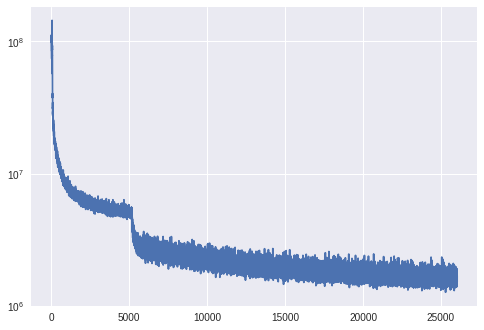

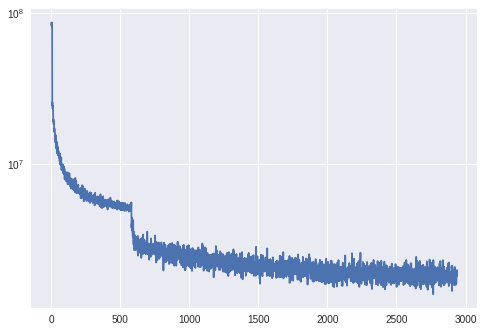

In [0]:
with open('loss.txt') as f:
    loss = f.read().splitlines()
with open('valid.txt') as f:
    valid_loss = f.read().splitlines()

loss = [float(loss_val) for loss_val in loss]
valid_loss = [float(valid_val) for valid_val in valid_loss]

# impactData = [loss, valid_loss]
# for impacts in impactData:
#     timefilteredForce = plt.plt(impacts)
#     timefilteredForce = plt.xlabel('points')
#     timefilteredForce = plt.ylabel('Force')
plt.semilogy(loss)
plt.show()

plt.semilogy(valid_loss)
plt.show()

In [0]:
from skimage.measure import compare_ssim as ssim

def calc_ssim(img1, img2):
    

    img1 = img1.astype(np.float32).reshape(64, 64)
    img2 = img2.astype(np.float32).reshape(64, 64)
    
    
    return np.sum(np.power(img1-img2,2))/4096

# Test Reconstruction
from scipy import ndimage

def create_noise(mean=0, sd=1, dim=(64,64,1), scale=0.3):
    return scale*255*np.random.normal(mean, sd, dim)

uint8
SSIM - WithItself:  1.0
SSIM - Noise:  0.09558366476019825
SSIM - CNN-AE:  0.4863743354834181
SSIM - Median:  0.28360144426836476


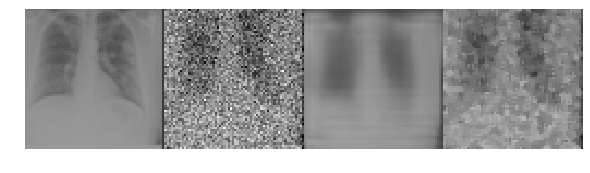

In [0]:
batch_norm = test_get_next_batch(0, 32)
batch_noise = [(image + create_noise()) for image in batch_norm]
batch_median = [ndimage.median_filter(noise, 3) for noise in batch_noise]
batch_recon = model.reconstructor(batch_noise)

n = np.sqrt(model.batch_size).astype(np.int32)
print(batch_norm[0].dtype)

I_reconstructed = np.empty((h*n, 3*w*n))


# for i in range(n):
#     for j in range(n):
#         x = np.concatenate((x_reconstructed.reshape(h, w), batch[0].reshape(h, w)), axis = 1)
#         I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = x # : in list defines range

I_reconstructed = np.concatenate((batch_norm[0], batch_noise[0], batch_recon[0], batch_median[0]), axis = 1).reshape(64, 256)

plt.figure(figsize=(10, 20))
plt.axis('off')
plt.imshow(I_reconstructed, cmap='gray')
# plt.savefig(os.path.join(pathdir, 'reconstructed.png'))

print("SSIM - WithItself: ", calc_ssim(batch_norm[0], batch_norm[0]))
print("SSIM - Noise: ", calc_ssim(batch_norm[0], batch_noise[0]))
print("SSIM - CNN-AE: ", calc_ssim(batch_norm[0], batch_recon[0]))
print("SSIM - Median: ", calc_ssim(batch_norm[0], batch_median[0]))

In [0]:
counter = 0
total_noise = 0
total_recon = 0
total_median = 0
for i in range(250//32):
    
    batch_norm = test_get_next_batch(0, 32)
    batch_noise = [(image + create_noise(mean=0, sd=1, dim=(64,64,1), scale=0.0)) for image in batch_norm]
    batch_median = [ndimage.median_filter(noise, 3) for noise in batch_noise]
    batch_recon = model.reconstructor(batch_noise)

    n = np.sqrt(model.batch_size).astype(np.int32)


    I_reconstructed = np.empty((h*n, 3*w*n))


    # for i in range(n):
    #     for j in range(n):
    #         x = np.concatenate((x_reconstructed.reshape(h, w), batch[0].reshape(h, w)), axis = 1)
    #         I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = x # : in list defines range

    I_reconstructed = np.concatenate((batch_norm[0], batch_noise[0], batch_recon[0], batch_median[0]), axis = 1).reshape(64, 256)

#     plt.figure(figsize=(10, 20))
#     plt.axis('off')
#     plt.imshow(I_reconstructed, cmap='gray')
    # plt.savefig(os.path.join(pathdir, 'reconstructed.png'))
    for i in range(32):
        counter+=1
        total_noise += calc_ssim(batch_norm[i], batch_noise[i])
        total_recon += calc_ssim(batch_norm[i], batch_recon[i])
        total_median += calc_ssim(batch_norm[i], batch_median[i])
#     print("SSIM - WithItself: ", calc_ssim(batch_norm[0], batch_norm[0]))
#     print("SSIM - Noise: ", calc_ssim(batch_norm[0], batch_noise[0]))
#     print("SSIM - CNN-AE: ", calc_ssim(batch_norm[0], batch_recon[0]))
#     print("SSIM - Median: ", calc_ssim(batch_norm[0], batch_median[0]))

print("noise: ", total_noise/counter)
print("VAE: ", total_recon/counter)
print("Median", total_median/counter)

noise:  0.0
VAE:  429.8906128065927
Median 29.964878627232142


In [0]:
from skimage.measure import compare_ssim as ssim

x = np.array([[1000000,3],[1,0]])
y = np.array([[0,3],[1,0]])
print(ssim(x, y))


ValueError: ignored

253.88104 -0.99999994
229.0 18.0
0.5644660131806787


In [0]:
def convert_to_64(oldimagelist):
    from PIL import Image
    oldimagelist = [image_path for image_path in glob.glob("/content/drive/My Drive/ResearchDatav2/*.png")]
    correct = (64,64)
    progress = 0
    for images in oldimagelist:
        progress+=1
        img = Image.open(images) # image extension *.png,*.jpg
    
        if (np.array(img).shape != correct):
            new_width  = 64
            new_height = 64
            img = img.resize((new_width, new_height), Image.ANTIALIAS)

            img.save(images)
        if (progress % 10 == 0):
            print(progress)
